In [1]:
#!pip install pytorch-minimize

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import proxy_crm_modules as pCRM
from fractionalFlow import frac_flow
from pywaterflood import CrmCompensated

from timeit import default_timer as timer

In [3]:
np.set_printoptions(threshold=np.inf)

<h3><b>1. Data Preprocessing</b></h3>
<p>Here, we process data for better understanding of the structure and plan out the things we need to do toward the data. P2 and P4 are modified to replicate shut in condition.</p>

In [25]:
# Base case.
data_src = "D:/crmProject/crmp_code_test/proxy_crm/data/test/"
oil_prod = pd.read_excel(data_src + 'Base_PROD.xlsx', header=None)
prod = pd.read_excel(data_src + "Base_LIQUID.xlsx", header=None)
inj = pd.read_excel(data_src + "Base_INJ.xlsx", header=None)
time = pd.read_excel(data_src + "TIME.xlsx", header= None)
pressure = pd.read_excel(data_src + "Base_BHP.xlsx", header=None)
wor = pd.read_excel(data_src + "Base_WOR.xlsx", header=None)
cwi = pd.read_excel(data_src + "Base_CWI.xlsx", header=None)

train_size = int(0.75 * prod.shape[0])

<p>This section is for loading the one and two well shut-in cases.</p>

In [29]:
# Single well shut-in case.
prod_shut_in1 = pd.read_excel(data_src + "ShutIn1_LIQUID.xlsx", header= None)
oil_prod_shut_in1 = pd.read_excel(data_src + 'ShutIn1_PROD.xlsx', header=None)
inj_shut_in1 = pd.read_excel(data_src + "ShutIn1_INJ.xlsx", header=None)
pressure_shut_in1 = pd.read_excel(data_src + "ShutIn1_BHP.xlsx", header=None)
wor_shut_in1 = pd.read_excel(data_src + "ShutIn1_WOR.xlsx", header=None)
cwi_shut_in1 = pd.read_excel(data_src + "ShutIn1_CWI.xlsx", header=None)

# Two well shut-in case
prod_shut_in2 = pd.read_excel(data_src + "ShutIn2_PROD.xlsx", header= None)
inj_shut_in2 = pd.read_excel(data_src + "ShutIn2_INJ.xlsx", header=None)
pressure_shut_in2 = pd.read_excel(data_src + "ShutIn2_BHP.xlsx", header=None)
wor_shut_in2 = pd.read_excel(data_src + "ShutIn2_WOR.xlsx", header=None)
cwi_shut_in2 = pd.read_excel(data_src + "ShutIn2_CWI.xlsx", header=None)

<p>Now, we can split it into train-test data. It is divided into 75-25%</p>

In [6]:
#Create train-test dataset for non-shut-in.
inj_train = inj.values[1:train_size]
prod_train = prod.values[1:train_size]
oil_prod_train = oil_prod.values[1:train_size]
time_train = time.values[1:train_size].astype('float')
press_train = pressure.values[1:train_size]

inj_test = inj.values[train_size:]
prod_test = prod.values[train_size:]
oil_prod_test = oil_prod.values[train_size:]
time_test = time.values[train_size:].astype('float')
press_test = pressure.values[train_size:]

# for single well shut-in case.
inj_shut_in1_train = inj_shut_in1.values[1:train_size]
prod_shut_in1_train = prod_shut_in1.values[1:train_size]
press_shut_in1_train = pressure_shut_in1.values[1:train_size]

inj_shut_in1_test = inj_shut_in1.values[train_size:]
prod_shut_in1_test = prod_shut_in1.values[train_size:]
press_shut_in1_test = pressure_shut_in2.values[train_size:]

# for two well shut-in case.
inj_shut_in2_train = inj_shut_in2.values[1:train_size]
prod_shut_in2_train = prod_shut_in2.values[1:train_size]
press_shut_in2_train = pressure_shut_in2.values[1:train_size]

inj_shut_in2_test = inj_shut_in2.values[train_size:]
prod_shut_in2_test = prod_shut_in2.values[train_size:]
press_shut_in2_test = pressure_shut_in2.values[train_size:]

<h3><b>2A. Fitting Model - Base Case</b></h3>
<p>Now, let us start with base case, where there is no shut-in well.</p>

In [7]:
base_pcrm = pCRM.proxyCRM()

In [8]:
base_pcrm.fit(prod_train, inj_train, press_train, time_train[:,0],num_cores=4, ftol=1e-3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 12.525751650712714
        x: [ 1.718e-01  1.886e-01 ...  4.708e-01  5.341e-01]
      nit: 13
      jac: [ 1.525e+00  1.304e+00 ... -4.641e-01 -3.715e-01]
     nfev: 592
     njev: 16
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>]

lambda_ip: [0.17181871 0.18861221 0.18942788 0.16196659 0.14670001 0.16574537
 0.17783882 0.18096411 0.17726284 0.15872958 0.16109755 0.16687767
 0.20299486 0.1774209  0.15487519 0.17863811 0.18807821 0.17004505
 0.16522562 0.15720667]
tau: [1.26491878 1.13031124 1.1309577  1.05348014]
lambda_prod: [0.91807331 0.8432227  0.86154822 0.90895019]
tau_prim: [0.30326976 0.43688198 0.56651545 0.80689165]
prod index: [0.4036587  0.49124717 0.47077892 0.5340831 ]


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   14.6s


In [9]:
q_hat_train = base_pcrm.predict()
q_hat_test = base_pcrm.predict(inj = inj_test, time = time_test[:,0], prod=prod_test, press=press_test)

In [10]:
liquid = base_pcrm.predict(inj = inj.values, time = time.values[:,0].astype(float), prod=prod.values, press=pressure.values)
q_oil=frac_flow(wor=wor.values, liquid=liquid, lambda_ip=base_pcrm.lambda_ip, inj=inj.values)

                0
0    1.101941e-09
1    9.238430e-10
2    1.142139e-09
3    1.278809e-09
4    1.032044e-09
..            ...
360  2.004014e-02
361  2.101038e-02
362  2.202718e-02
363  2.318295e-02
364  2.430796e-02

[365 rows x 1 columns]


C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_21752\4191004026.py:1: RankWarning: Polyfit may be poorly conditioned
  q_oil.fit_fractional()
d:\crmProject\crmp_code_test\proxy_crm\main\fractionalFlow.py:80: RuntimeWarning: invalid value encountered in log
  y = beta * log_x - np.log(alpha)


array([[   0.        ,    0.        ,    0.        ,    0.        ],
       [ -95.84239177,  -97.5027263 , -110.45585254, -120.02301299],
       [-133.11302175, -163.2454674 , -128.49119334, -159.23009511],
       [-253.95429937, -229.44333617, -265.51578049, -192.19063966],
       [-152.55818431, -172.07352774, -152.12260457, -179.76807728],
       [-195.98694174, -188.04839167, -188.4261159 , -177.46588799],
       [-167.63520114, -204.93387422, -199.58900473, -221.93790951],
       [-258.77832729, -198.47302349, -213.72416891, -188.86270543],
       [-261.25499225, -228.84732392, -247.41978387, -291.78375584],
       [-156.13642083, -190.27562638, -200.62962047, -162.62350131],
       [-188.35917488, -213.30221878, -182.21552322, -203.87514442],
       [-208.81386353, -178.30960829, -248.75580073, -207.28045833],
       [-192.17943263, -249.3477734 , -173.27011917, -199.31181693],
       [-233.66668705, -171.62879017, -215.55135062, -208.07034276],
       [-208.00549427, -248.857285

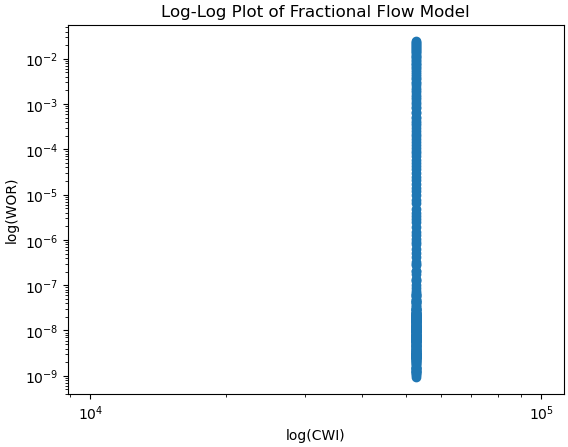

In [11]:
q_oil.fit_fractional()

<h3><b>2B. Fitting Model - Shut-in Case</b></h3>
<p>This time, we will be fitting model in shut-in case. There are two shut-in cases, one well (P2) shut-in and two wells (P2 and P4) shut-in.</p>

In [12]:
start = timer()
shut_in1_test = pCRM.proxyCRM()
shut_in1_test.fit(prod_shut_in1_train, inj_shut_in1_train, press_shut_in1_train, time_train[:,0],num_cores=4, ftol=1e-3)
end = timer()
print(end-start)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 10.423111439050148
        x: [ 1.485e-01  1.037e-01 ...  4.062e-01  4.942e-01]
      nit: 21
      jac: [ 2.655e+00  2.355e+00 ... -2.687e-01 -3.773e-01]
     nfev: 962
     njev: 26
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>]

lambda_ip: [0.14847121 0.10374726 0.49804676 0.064386   0.05310446 0.1685756
 0.06547788 0.49908893 0.08161814 0.05351603 0.09618257 0.04932395
 0.5349114  0.12105184 0.05762652 0.11250851 0.07714405 0.56598807
 0.05106735 0.03988573]
tau: [1.52159122 1.16367097 1.1330061  0.93731669]
lambda_prod: [0.92555682 0.70928939 0.781287   0.86746895]
tau_prim: [1.00000000e-04 1.00000000e-04 3.10876401e-01 5.73179289e-01]
prod index: [0.29607116 0.37882368 0.40624875 0.49422818]
25.309877200052142


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   25.2s


In [13]:
q_hat_sh_test = shut_in1_test.predict(inj = inj_shut_in1_test, time = time_test[:,0], prod = prod_shut_in1_test, press= press_shut_in1_test)
q_hat_sh_train = shut_in1_test.predict()

In [14]:
start = timer()
shut_in2_test = pCRM.proxyCRM()
shut_in2_test.fit(prod_shut_in2_train, inj_shut_in2_train, press_shut_in2_train, time_train[:,0],num_cores=4, ftol=1e-3)
end = timer()
print(end-start)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8.67445821492429
        x: [ 1.499e-01  8.235e-02 ...  3.738e-01  5.504e-01]
      nit: 25
      jac: [-1.114e-01 -2.442e-01 ... -4.231e-01 -9.601e-02]
     nfev: 1036
     njev: 28
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>]

lambda_ip: [0.14988642 0.08234745 0.52310109 0.06004065 0.04372137 0.12671364
 0.06286677 0.54767372 0.07801455 0.03674058 0.12107057 0.02104717
 0.54132972 0.10393132 0.07255907 0.09531771 0.09490444 0.52017355
 0.07478074 0.0627457 ]
tau: [1.50474464 1.14328521 1.09073893 0.89742407]
lambda_prod: [0.82273803 0.8038556  0.86578909 0.89963428]
tau_prim: [0.15549462 0.3611847  0.62555793 0.77498687]
prod index: [0.30162014 0.4306157  0.37376268 0.55035333]
58.19822409981862


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   58.1s


In [15]:
q_hat_sh2_test = shut_in2_test.predict(inj = inj_shut_in2_test, time = time_test[:,0], prod = prod_shut_in2_test, press= press_shut_in2_test)
q_hat_sh2_train = shut_in2_test.predict()

PYWATERFLOOD TEST

In [16]:
crm = CrmCompensated(tau_selection='per-pair', constraints='up-to one')
crm.fit(prod_train, press_train, inj_train, time_train[:,0], num_cores=4)

In [17]:
q_hat_crmip = crm.predict()
q_hat_crmip_test = crm.predict(injection = inj_test, time = time_test[:,0], production=prod_test)

In [18]:
crm_sh1 = CrmCompensated(tau_selection='per-pair', constraints='up-to one')
crm_sh1.fit(prod_shut_in1_train, press_shut_in1_train, inj_shut_in1_train, time_train[:,0],num_cores=4)

In [19]:
q_hat_sh1_crmip = crm_sh1.predict()
q_hat_sh1_test_crmip = crm_sh1.predict(injection = inj_shut_in1_test, time = time_test[:,0], production = prod_shut_in1_test)

In [20]:
crm_sh2 = CrmCompensated(tau_selection='per-pair', constraints='up-to one')
crm_sh2.fit(prod_shut_in2_train, press_shut_in2_train, inj_shut_in2_train, time_train[:,0],num_cores=4)

KeyboardInterrupt: 

In [ ]:
q_hat_sh2_crmip = crm_sh2.predict()
q_hat_sh2_test_crmip = crm_sh2.predict(injection = inj_shut_in2_test, time = time_test[:,0], production = prod_shut_in2_test)

TESTING FRACTIONAL FLOW

In [ ]:
q_oil = f_oil.calculate_ff()

In [ ]:
print(f"{q_oil[0]}\n{prod_shut_in_train[0]*0.95}")

<h3><b>3. Display Results</b></h3>
<p>Let's display all of the results that we have gotten now!</p>

In [ ]:
import scienceplots
plt.style.use(['science', 'no-latex'])

In [ ]:
fig, axes = plt.subplots(len(prod.columns), figsize=(11, 8), sharey=True)
for i, p in enumerate(prod):
    axes[i].plot(time_train, prod_train[:,p], label=f"Train")
    axes[i].plot(time_test, prod_test[:,p], label=f"Test")

    axes[i].plot(time_train, q_hat_train[:,p], ls="--", label=f"Train Prediction -- proxy-CRM", lw=2)
    axes[i].plot(time_test, q_hat_test[:,p], ls="--", label=f"Test Prediction -- proxy-CRM", lw=2)

    axes[i].plot(time_train, q_hat_crmip[:,p], ls=":", label=f"Train Prediction -- CRMIP", lw=3)
    axes[i].plot(time_test, q_hat_crmip_test[:,p], ls=":", label=f"Test Prediction -- CRMIP", lw=3)
    
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p+1}", xy=(10, 10), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    axes[i].grid(visible=True, which='both')
axes[i].set(xlabel="Time")
axes[0].set(title='Liquid Production Rate Prediction - Base Case')
legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

In [ ]:
fig, axes = plt.subplots(len(prod.columns), figsize=(11, 8), sharex=True)

for i, p in enumerate(prod):
    axes[i].plot(time_train, prod_shut_in1_train[:,p], label=f"Train")
    axes[i].plot(time_test, prod_shut_in1_test[:,p], label=f"Test")

    axes[i].plot(time_train, q_hat_sh_train[:,p], ls="--", label=f"Train Prediction -- proxy-CRM", lw=2)
    axes[i].plot(time_test, q_hat_sh_test[:,p], ls="--", label=f"Test Prediction -- proxy-CRM", lw=2)

    axes[i].plot(time_train, q_hat_sh1_crmip[:,p], ls=":", label=f"Train Prediction -- CRMIP", lw=3)
    axes[i].plot(time_test, q_hat_sh1_test_crmip[:,p], ls=":", label=f"Test Prediction -- CRMIP", lw=3)
    
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p+1}", xy=(10, 10), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    axes[i].grid(visible=True, which='both')
axes[i].set(xlabel="Time")
axes[0].set(title='Liquid Production Rate Prediction - One Well Shut-in Case')

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

fig = plt.show()

In [ ]:
fig, axes = plt.subplots(len(prod.columns), figsize=(11, 8), sharex=True)

for i, p in enumerate(prod):
    axes[i].plot(time_train, prod_shut_in2_train[:,p], label=f"Train")
    axes[i].plot(time_test, prod_shut_in2_test[:,p], label=f"Test")
    
    axes[i].plot(time_train, q_hat_sh2_train[:,p], ls="--", label=f"Train Prediction -- proxy-CRM", lw=2)
    axes[i].plot(time_test, q_hat_sh2_test[:,p], ls="--", label=f"Test Prediction -- proxy-CRM", lw=2)

    axes[i].plot(time_train, q_hat_sh2_crmip[:,p], ls=":", label=f"Train Prediction -- CRMIP", lw=3)
    axes[i].plot(time_test, q_hat_sh2_test_crmip[:,p], ls=":", label=f"Test Prediction -- CRMIP", lw=3)

    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p+1}", xy=(10, 10), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    axes[i].grid(visible=True, which='both')
axes[i].set(xlabel="Time")
axes[0].set(title='Liquid Production Rate Prediction - Two Well Shut-in Case')

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

fig = plt.show()

In [ ]:
connectivity = pd.DataFrame(
    base_pcrm.lambda_ip.reshape(4,5),
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
connectivity.T.style.highlight_max(color='blue').format("{:.2}")

In [ ]:
shut_in_connectivity = pd.DataFrame(
    shut_in1_test.lambda_ip.reshape(4,5),
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
shut_in_connectivity.T.style.highlight_max(color='blue').format("{:.2}")

In [ ]:
shut_in_connectivity2 = pd.DataFrame(
    shut_in2_test.lambda_ip.reshape(4,5),
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
shut_in_connectivity.T.style.highlight_max(color='blue').format("{:.2}")

In [ ]:
def rmse(test, pred, test_sh, pred_sh, test_sh2, pred_sh2):
  original_rmse = np.sqrt(((test-pred)**2/len(test)).sum())
  shut_in_rmse = np.sqrt(((test_sh-pred_sh)**2/len(test_sh)).sum())
  shut_in_rmse2 = np.sqrt(((test_sh2-pred_sh2)**2/len(test_sh)).sum())
  return original_rmse, shut_in_rmse, shut_in_rmse2

result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(prod_test[:,j], q_hat_test[:,j], prod_shut_in1_test[:,j], q_hat_sh_test[:,j], prod_shut_in2_test[:,j], q_hat_sh2_test[:,j])))

print(f'Test Prediction RMSE of proxy-CRM:\n{np.array(result)}')

In [ ]:
result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(prod_train[:,j], q_hat_train[:,j], prod_shut_in1_train[:,j], q_hat_sh_train[:,j], prod_shut_in2_train[:,j], q_hat_sh2_train[:,j])))

print(f'Train Prediction RMSE of proxy-CRM:\n{np.array(result)}')

In [ ]:
result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(prod_test[:,j], q_hat_crmip_test[:,j], prod_shut_in1_test[:,j], q_hat_sh1_test_crmip[:,j], prod_shut_in2_test[:,j], q_hat_sh2_test_crmip[:,j])))

print(f'Test Prediction RMSE of CRMIP:\n{np.array(result)}')

In [ ]:
result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(prod_train[:,j], q_hat_crmip[:,j], prod_shut_in1_train[:,j], q_hat_sh1_crmip[:,j], prod_shut_in2_train[:,j], q_hat_sh2_crmip[:,j])))

print(f'Train Prediction RMSE of CRMIP:\n{np.array(result)}')

In [ ]:
n_prod = prod_shut_in2_train.shape[1]
n_inj = inj_train.shape[1]
n_t = prod.values.shape[0]

lambda_ip = np.tile(shut_in2_test.lambda_ip.reshape((n_prod,n_inj)), (n_t,1,1))

mask = pCRM.sh_mask(prod_shut_in2_train)
result = pCRM.calc_sh_mask(lambda_ip, mask)

print(result[:,3,:])